## Null-Text Inversion

Paper Link: (https://arxiv.org/abs/2211.09794)

### Overview

Text guided Diffusion models are all the rage these days. A lot of people are trying to figure out how one can manipulate or edit the images using these state of the art tools. 
In this blog we explore a technique called Null-Text Inversion for real image editing using text input. The authors of the paper achieve this in three steps:
1. Inversion: The goal of this step is to find a noise vector that approximately produces the input image when fed with the input prompt into the diffusion process while preserving the editing capabilities of the model. Authors use DDIM inversion for this step. 

What goes in and what comes out:

goes in: input image, input prompt
comes out: noise vector(s) 

2. Null-Text Optimisation: Optmizing the unconditional text embedding to invert the input image and input prompt


What goes in and what comes out:

goes in: noise vector(s) obtained in step 1, input prompt
comes out: optimised unconditional embeddings

3. Edited Image generation: Diffuse the image with edited prompt and Null-text and Noise vector obtained from Steps 1 and 2


What goes in and what comes out:

goes in: edited text prompt, noise vector(s) obtained in step 1, optimised unconditional embeddings obtained in step 2
comes out: edited image


### Install packages

In [1]:
!pip install diffusers torch torchvision transformers matplotlib fastai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.1/453.1 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.8.1
    Uninstalling huggingface-hub-0.8.1:
      Successfully uninstalled huggingface-hub-0.8.1


### Imports 

In [2]:
from diffusers import StableDiffusionPipeline, DDIMScheduler
import torch
import requests
from PIL import Image
from io import BytesIO
import numpy as np
from fastai.vision.all import *
from matplotlib import pyplot as plt

has_cuda = torch.cuda.is_available()
device = torch.device('cpu' if not has_cuda else 'cuda')

### Setup 'pipe'

In [3]:
model_id_or_path = "CompVis/stable-diffusion-v1-4"
scheduler = DDIMScheduler.from_config(model_id_or_path, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(
    model_id_or_path,
    safety_checker=None,
    use_auth_token=True,
    scheduler = scheduler,
).to(device)

/usr/local/lib/python3.9/dist-packages/diffusers/utils/deprecation_utils.py:35: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddim.DDIMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  warnings.warn(warning + message, FutureWarning)


Downloading:   0%|          | 0.00/313 [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/592 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


## Load our inputs (image and prompt describing the input image)

In [32]:
def load_inps(impath, input_prompt):
    image = Image.open(impath).convert("RGB")
    image = image.resize((512, 512))

    def preprocess_image(image):
        image = np.array(image.convert("RGB"))
        image = image[None].transpose(0, 3, 1, 2)
        image = torch.from_numpy(image).to(dtype=torch.float32) / 127.5 - 1.0
        return image

    pp_image = preprocess_image(image)

    generator = torch.Generator(device=device)
    latent = pipe.vae.encode(pp_image.to(device)).latent_dist.sample(generator=generator) *  0.18215

    text_embeddings = pipe._encode_prompt(input_prompt, device, 1, False, None)
    return latent, text_embeddings 

## DDIM Inversion

![alt text](assets/DDIM_inversion%20(1).jpg "DDIM Inversion")

In [5]:
from fastai.vision.all import *

In [6]:
@torch.no_grad()
def ddim_inversion(latents, encoder_hidden_states, noise_scheduler, unet):
    next_latents = latents
    all_latents = [latents.detach().cpu()]

    # since we are adding noise to the image, we reverse the timesteps list to start at t=0
    reverse_timestep_list = reversed(noise_scheduler.timesteps)  
    
    for i in range(len(reverse_timestep_list)-1):
        timestep = reverse_timestep_list[i]
        next_timestep = reverse_timestep_list[i+1] 
        latent_model_input = noise_scheduler.scale_model_input(next_latents, timestep)
        noise_pred = unet(latent_model_input, timestep, encoder_hidden_states).sample

        alpha_prod_t =  noise_scheduler.alphas_cumprod[timestep]
        alpha_prod_t_next = noise_scheduler.alphas_cumprod[next_timestep]
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_next = 1 - alpha_prod_t_next

        f = (next_latents - beta_prod_t ** 0.5 * noise_pred) / (alpha_prod_t ** 0.5)
        next_latents = alpha_prod_t_next ** 0.5 * f + beta_prod_t_next ** 0.5 * noise_pred
        all_latents.append(next_latents.detach().cpu())


    return all_latents

In [7]:
num_inference_steps = 50
pipe.scheduler.set_timesteps(num_inference_steps, device=device)
all_latents = ddim_inversion(latent, text_embeddings, pipe.scheduler, pipe.unet)

In [8]:
z_T = all_latents[-1].to(device)
im = pipe(prompt=prompt, latents=z_T, generator=generator)

  0%|          | 0/50 [00:00<?, ?it/s]

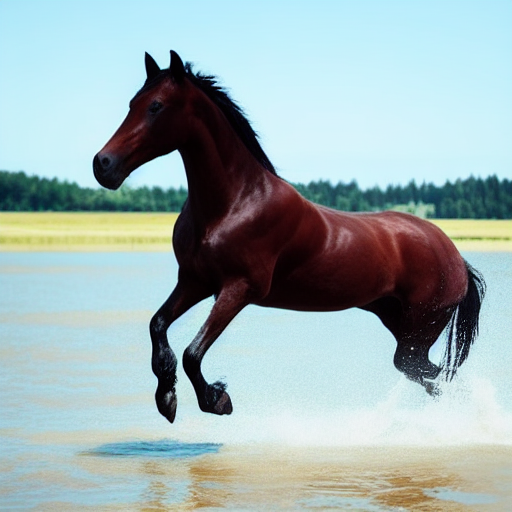

In [9]:
im[0][0]

## Null-text Optimisation

![alt text](assets/null_text_opt%20(1).jpg "Null Text Optimisation")

In [16]:
def null_text_inversion(
    pipe,
    all_latents,
    prompt,
    num_opt_steps=15,
    lr=0.01,
    tol=1e-5,
    guidance_scale=7.5,
    eta: float = 0.0,
    generator = None
):
    
    # initialise null text embeddings
    null_text_prompt = ""
    null_text_input = pipe.tokenizer(
        null_text_prompt,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        truncaton=True,
        return_tensors="pt",
    )
    
    # prepare for optimising
    null_text_embeddings = torch.nn.Parameter(pipe.text_encoder(null_text_input.input_ids.to(pipe.device))[0], requires_grad=True)
    null_text_embeddings = null_text_embeddings.detach()
    null_text_embeddings.requires_grad_(True)

    
    # Initialize the optimizer
    optimizer = torch.optim.Adam(
        [null_text_embeddings],  # only optimize the embeddings
        lr=lr,
    )

    # step_ratio = pipe.scheduler.config.num_train_timesteps // pipe.scheduler.num_inference_steps
    text_embeddings = pipe._encode_prompt(prompt, device, 1, False, None).detach()
    # input_embeddings = torch.cat([null_text_embeddings, text_embeddings], dim=0)
    extra_step_kwargs = pipe.prepare_extra_step_kwargs(generator, eta)
    all_null_texts = []
    latents = all_latents[-1]
    latents = latents.to(pipe.device)
    for timestep, prev_latents in pipe.progress_bar(zip(pipe.scheduler.timesteps, reversed(all_latents[:-1]))):
        prev_latents = prev_latents.to(pipe.device).detach()
        
        # expand the latents if we are doing classifier free guidance
        latent_model_input = pipe.scheduler.scale_model_input(latents, timestep).detach()
        noise_pred_text = pipe.unet(latent_model_input, timestep, encoder_hidden_states=text_embeddings).sample.detach()
        for _ in range(num_opt_steps):
            # predict the noise residual
            noise_pred_uncond = pipe.unet(latent_model_input, timestep, encoder_hidden_states=null_text_embeddings).sample

            # perform guidance
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            prev_latents_pred = pipe.scheduler.step(noise_pred, timestep, latents, **extra_step_kwargs).prev_sample
            loss = torch.nn.functional.mse_loss(prev_latents_pred, prev_latents).mean()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        all_null_texts.append(null_text_embeddings.detach().cpu())
        latents = prev_latents_pred.detach()
    return all_latents[-1], all_null_texts

In [17]:
z_T, all_null_texts = null_text_inversion(pipe, all_latents, prompt, num_opt_steps=15)

Keyword arguments {'truncaton': True} not recognized.


0it [00:00, ?it/s]

In [19]:
@torch.no_grad()
def reconstruct(pipe, latents, prompt, null_text_embeddings, guidance_scale=7.5, generator=None, eta=0.0):
    text_embeddings = pipe._encode_prompt(prompt, device, 1, False, None)
    extra_step_kwargs = pipe.prepare_extra_step_kwargs(generator, eta)
    latents = latents.to(pipe.device)
    for i, (t, null_text_t) in enumerate(pipe.progress_bar(zip(pipe.scheduler.timesteps, null_text_embeddings))):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        input_embedding = torch.cat([null_text_t.to(pipe.device), text_embeddings])
        # predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=input_embedding).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = pipe.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

    #Post-processing
    image = pipe.decode_latents(latents)
    return image

In [20]:
recon_img = reconstruct(pipe, z_T, prompt, all_null_texts, guidance_scale=1)

0it [00:00, ?it/s]

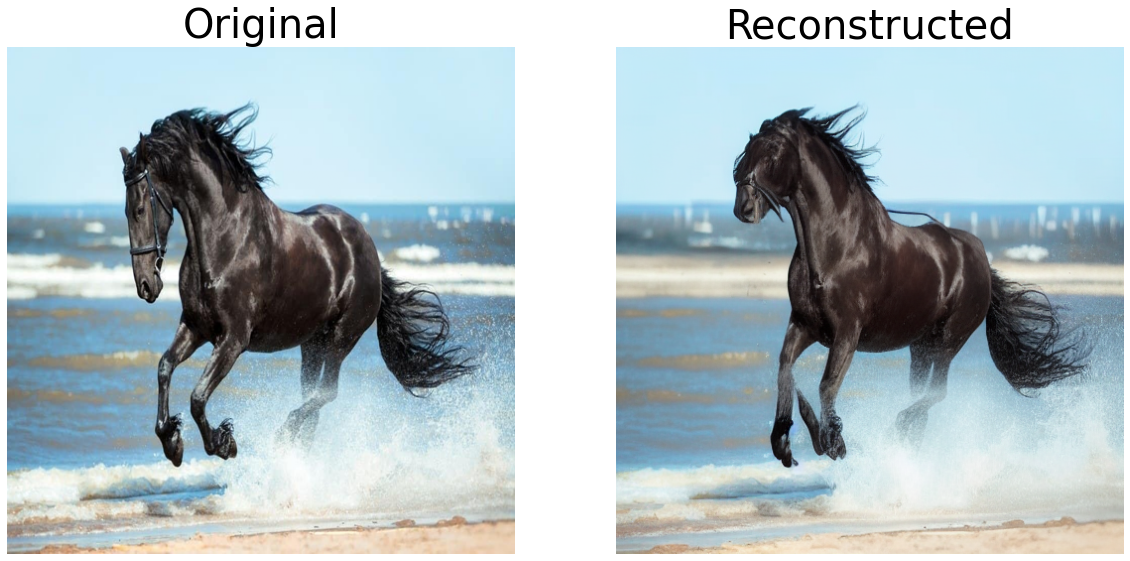

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(pp_image[0].permute(1,2,0).numpy() * 0.5 + 0.5)
ax[0].set_title("Original", fontdict={'fontsize': 40})
ax[0].axis('off')

ax[1].imshow(recon_img[0])
ax[1].set_title("Reconstructed", fontdict={'fontsize': 40})
ax[1].axis('off')

plt.show()

## Editing the Inverted image

0it [00:00, ?it/s]

<AxesSubplot:>

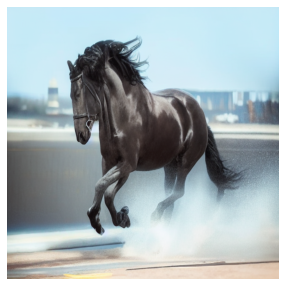

In [24]:
edit_prompt = "A horse running in a city"
edit_img = reconstruct(pipe, z_T, edit_prompt, all_null_texts, guidance_scale=1.0)
show_image(edit_img.squeeze())

0it [00:00, ?it/s]

<AxesSubplot:>

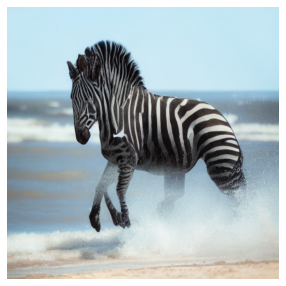

In [26]:
edit_prompt = "A zebra running on water"
edit_img = reconstruct(pipe, z_T, edit_prompt, all_null_texts, guidance_scale=1.0)
show_image(edit_img.squeeze())

0it [00:00, ?it/s]

<AxesSubplot:>

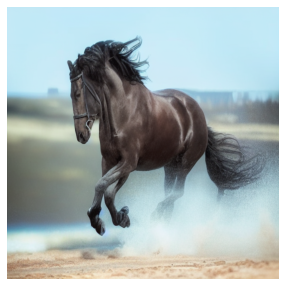

In [29]:
edit_prompt = "A horse running on a green fied"
edit_img = reconstruct(pipe, z_T, edit_prompt, all_null_texts, guidance_scale=1.0)
show_image(edit_img.squeeze())